## Device check

In [1]:
!nvidia-smi

Wed Nov  8 04:50:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   27C    P0    40W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Packages

In [2]:
import warnings
warnings.filterwarnings(action="ignore")

In [3]:

import lightning.pytorch as pl
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import RichProgressBar, TQDMProgressBar, ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger


import logging
logging.basicConfig(level="INFO")

import math
from matplotlib import pyplot
%matplotlib inline

import numpy as np

import os

import pandas as pd
from pprint import pprint

import sys
sys.path.append("../src")

import timm
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torchmetrics.text import CharErrorRate, WordErrorRate
from typing import Tuple, Union


In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
%load_ext autoreload
%autoreload 2


In [14]:
import config
from dataloader import BEDataset, BEDataModule
import token_learner
from transformer import PositionalEncoder, SelfAttentionHead, MultiHeadSelfAttention, FeedFowardLayer, LayerNormalization, TransformerDecoderLayer, TransformerDecoder, generate_causal_attention_mask

from film_layers import FiLMBlockV2, FiLMEncoder, ResBlockDWConv
from rt1 import RT1Encoder, RT1Decoder, ActionGenerator, RT1CRAM
from utils.data_utils import History
import utils.model_utils as model_utils
from utils.model_utils import TextEncoder, ImageFeatureExtractor, plot_attention, fetch_random_sample_from_batch, greedy_decoding, decode_predictions


## Data Module

In [6]:
dm = BEDataModule()
dm.setup()

INFO:root:Training on 3822 samples.
INFO:root:Validating on 686 samples.
INFO:root:Testing on 250 samples.


Total # examples: 4758


## Fetch batch

In [7]:
# batch = next(iter(dm.test_dataloader()))
# print(batch.keys())
# batch["in_state"].shape

In [8]:
%%time
batch = next(iter(dm.train_dataloader()))
print(batch.keys())
batch["in_state"].shape

dict_keys(['sample_id', 'in_state', 'action_desc', 'source_mask_tokens', 'source_mask', 'motor_cmd', 'target_mask'])
CPU times: user 939 ms, sys: 953 ms, total: 1.89 s
Wall time: 8.92 s


torch.Size([16, 3, 288, 288])

In [9]:
# batch["source_mask"].shape, batch["target_mask"].shape

In [10]:
# batch["motor_cmd"]["labels"]

In [11]:
input_ids=batch["action_desc"]["ids"].cuda()
attn_mask=batch["action_desc"]["mask"].cuda()
token_type_ids=batch["action_desc"]["token_type_ids"].cuda()
imgs=batch["in_state"].cuda()
decoder_inp=batch["motor_cmd"]["decoder_inp_ids"].cuda()
src_mask=(batch["source_mask"].cuda(), batch["source_mask_tokens"].cuda())
target_mask=batch["target_mask"].cuda()


## Model Design
<!-- ![RT1 model architecture](../../imgs/rt1+.png) -->
<center>
    <img src="../imgs/rt1+.png" alt="RT1 model architecture" width="300" height="400">

<center>

### Encoder

#### Test Text Encoder

In [16]:
# te = TextEncoder(freeze=True).cuda()
# summary(model=te, col_names=["num_params", "trainable"])

In [ ]:
# emb, inp_seq_enc = te(
#     inp_ids=batch["action_desc"]["ids"].cuda(),
#     mask=batch["action_desc"]["mask"].cuda(),
#     tok_type_ids=batch["action_desc"]["token_type_ids"].cuda()
# )

# emb.shape, inp_seq_enc.shape

#### Test Img Feature Extractor

In [ ]:
# fe = ImageFeatureExtractor(pretrained=True, arch="efficientnet_b3").cuda()

# summary(fe, col_names=["num_params", "trainable"])

In [ ]:
# img_ftrs = fe(batch["in_state"].cuda())

# img_ftrs.shape

#### Test FiLM Block

In [16]:
# film_block = FiLMBlockV2().cuda()
# print(film_block)
# summary(model=film_block)

In [17]:
# text_cond_ftrs = film_block(
#     img_features=img_ftrs, 
#     conditioning=emb
# )

# text_cond_ftrs.shape

#### Test Residual FiLM Block

In [18]:
# dw_res = ResBlockDWConv(512, 512).cuda()
# summary(model=dw_res)

In [19]:
# text_cond_ftrs_res = dw_res(
#     img_features=img_ftrs, 
#     conditioning=emb
# )

# text_cond_ftrs_res.shape

#### Test FiLM Encoder

In [32]:
film_encoder = FiLMEncoder(
    arch="resnet18",
    n_res_blocks=6,
).cuda()

# print(film_encoder)
summary(model=film_encoder)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Layer (type:depth-idx)                             Param #
FiLMEncoder                                        --
├─ImageFeatureExtractor: 1-1                       --
│    └─FeatureListNet: 2-1                         --
│    │    └─Conv2d: 3-1                            (9,408)
│    │    └─BatchNorm2d: 3-2                       (128)
│    │    └─ReLU: 3-3                              --
│    │    └─MaxPool2d: 3-4                         --
│    │    └─Sequential: 3-5                        (147,968)
│    │    └─Sequential: 3-6                        (525,568)
│    │    └─Sequential: 3-7                        (2,099,712)
│    │    └─Sequential: 3-8                        (8,393,728)
│    └─VisionLanguageHead: 2-2                     --
│    │    └─Conv2d: 3-9                            262,656
│    │    └─GELU: 3-10                             --
│    │    └─AdaptiveMaxPool2d: 3-11                --
├─ModuleList: 1-2                                  --
│    └─ResBlockDWConv: 2-3      

In [36]:
# %%time

# out = film_encoder(
#     x= batch["in_state"].cuda(),
#     conditioning=inp_emb
# )

# out.shape

#### Token Learner

In [37]:
# N, C, H_W = out.shape
# N, C, H_W

In [38]:
# tokL_v11 = token_learner.TokenLearnerModuleV11(feature_shape=(N, H_W, C)).cuda()
# print(tokL_v11)
# summary(model=tokL_v11)

In [24]:
# learned_tokens = tokL_v11(out.view(N, H_W, C))
# learned_tokens.shape

In [39]:
# tokenized_inputs = torch.empty((B, config.NUM_HISTORY+1, config.D_MODEL, config.NUM_LEARNED_TOKENS))
# tokenized_inputs.shape

#### RT-1 Encoder

In [41]:
encoder = RT1Encoder(
    cnn_bacnbone="efficientnet_b3", 
    num_res_blocks=6, 
    freeze_cnn_backbone=True
).to(config.DEVICE)

summary(model=encoder, col_names=["num_params", "trainable"])

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b3.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnet_b3.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Layer (type:depth-idx)                                       Param #                   Trainable
RT1Encoder                                                   --                        Partial
├─TextEncoder: 1-1                                           --                        False
│    └─BertModel: 2-1                                        --                        False
│    │    └─BertEmbeddings: 3-1                              (15,891,456)              False
│    │    └─BertEncoder: 3-2                                 (12,609,536)              False
│    │    └─BertPooler: 3-3                                  (262,656)                 False
│    └─Dropout: 2-2                                          --                        --
├─FiLMEncoder: 1-2                                           --                        Partial
│    └─ImageFeatureExtractor: 2-3                            --                        Partial
│    │    └─EfficientNetFeatures: 3-4                        (1

In [43]:
%%time

text_enc_h_state, learned_tokens = encoder(
    input_ids=input_ids,
    attn_mask=attn_mask,
    token_type_ids=token_type_ids,
    imgs=imgs
)

learned_tokens.shape, text_enc_h_state.shape

CPU times: user 202 ms, sys: 234 ms, total: 436 ms
Wall time: 11.4 s


(torch.Size([1, 48, 512]),
 device(type='cuda', index=0),
 torch.Size([1, 16, 512]))

### Decoder

In [20]:
inp_embedding = encoder.text_encoder.encoder.embeddings

target_embedding = nn.Embedding(
    num_embeddings=config.TARGET_VOCAB_SIZE, 
    embedding_dim=config.EMBEDDING_DIM, 
    padding_idx=config.TGT_PAD_TOK_ID
).cuda()

In [44]:
inp = input_ids
outp = decoder_inp

inp_emb = inp_embedding(inp)
outp_emb = target_embedding(outp)

inp_emb.shape, outp_emb.shape

(torch.Size([1, 16, 512]), torch.Size([1, 16, 512]))

#### Test MultiHead Self-Attention Layer

In [248]:
# sa = SelfAttentionHead().cuda()
# sa.eval()
# print(sa)
# summary(sa)

In [298]:
# %%time

# mem, attn_w = sa(
#     q=inp_emb, 
#     k=inp_emb, 
#     v=inp_emb, 
#     mask=batch["target_mask"].cuda(),
#     return_weights=True
# )

# mem.shape, attn_w.shape

CPU times: user 2.38 ms, sys: 5 ms, total: 7.38 ms
Wall time: 209 ms


(torch.Size([4, 16, 512]), torch.Size([4, 16, 16]))

In [250]:
# plot_attention(attn_w)

In [251]:
mhsa = MultiHeadSelfAttention(num_heads=4).cuda()
mhsa.eval()
print(mhsa)
summary(mhsa)

MultiHeadSelfAttention(
  (attention_heads): ModuleList(
    (0-3): 4 x SelfAttentionHead(
      (dropout): Dropout(p=0.1, inplace=False)
      (_softmax): Softmax(dim=-1)
      (w_q): Linear(in_features=512, out_features=512, bias=False)
      (w_k): Linear(in_features=512, out_features=512, bias=False)
      (w_v): Linear(in_features=512, out_features=512, bias=False)
    )
  )
  (output_layer): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=False)
    (1): Dropout(p=0.1, inplace=False)
  )
)


Layer (type:depth-idx)                   Param #
MultiHeadSelfAttention                   --
├─ModuleList: 1-1                        --
│    └─SelfAttentionHead: 2-1            --
│    │    └─Dropout: 3-1                 --
│    │    └─Softmax: 3-2                 --
│    │    └─Linear: 3-3                  262,144
│    │    └─Linear: 3-4                  262,144
│    │    └─Linear: 3-5                  262,144
│    └─SelfAttentionHead: 2-2            --
│    │    └─Dropout: 3-6                 --
│    │    └─Softmax: 3-7                 --
│    │    └─Linear: 3-8                  262,144
│    │    └─Linear: 3-9                  262,144
│    │    └─Linear: 3-10                 262,144
│    └─SelfAttentionHead: 2-3            --
│    │    └─Dropout: 3-11                --
│    │    └─Softmax: 3-12                --
│    │    └─Linear: 3-13                 262,144
│    │    └─Linear: 3-14                 262,144
│    │    └─Linear: 3-15                 262,144
│    └─SelfAttentionHead: 

In [279]:
%%time

mem, attn_w = mhsa(
    q=inp_emb, 
    k=inp_emb, 
    v=inp_emb, 
    mask=batch["target_mask"].cuda(),
    return_weights=True
)

mem.shape, attn_w.shape

CPU times: user 2.73 ms, sys: 79 µs, total: 2.81 ms
Wall time: 2.28 ms


(torch.Size([4, 16, 512]), torch.Size([4, 4, 16, 16]))

In [280]:
attn_w[0, 0, 0]

tensor([0.0606, 0.0543, 0.0559, 0.0649, 0.0481, 0.0547, 0.0406, 0.0551, 0.0659,
        0.0666, 0.0759, 0.0744, 0.0740, 0.0715, 0.0697, 0.0679],
       device='cuda:0', grad_fn=<SelectBackward0>)

#### Plot Self-attention weights

In [16]:
# plot_attention(attn_w)
# plot_attention(attn_w, example_idx=2)

#### Test Cross Attention Layer

In [282]:
# num_heads = 2

# cross_attention = MultiHeadSelfAttention(
#     num_heads=num_heads
# ).cuda()

# cross_attention.eval()
# print(cross_attention)
# summary(cross_attention)

MultiHeadSelfAttention(
  (attention_heads): ModuleList(
    (0-1): 2 x SelfAttentionHead(
      (dropout): Dropout(p=0.1, inplace=False)
      (_softmax): Softmax(dim=-1)
      (w_q): Linear(in_features=512, out_features=512, bias=False)
      (w_k): Linear(in_features=512, out_features=512, bias=False)
      (w_v): Linear(in_features=512, out_features=512, bias=False)
    )
  )
  (output_layer): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=False)
    (1): Dropout(p=0.1, inplace=False)
  )
)


Layer (type:depth-idx)                   Param #
MultiHeadSelfAttention                   --
├─ModuleList: 1-1                        --
│    └─SelfAttentionHead: 2-1            --
│    │    └─Dropout: 3-1                 --
│    │    └─Softmax: 3-2                 --
│    │    └─Linear: 3-3                  262,144
│    │    └─Linear: 3-4                  262,144
│    │    └─Linear: 3-5                  262,144
│    └─SelfAttentionHead: 2-2            --
│    │    └─Dropout: 3-6                 --
│    │    └─Softmax: 3-7                 --
│    │    └─Linear: 3-8                  262,144
│    │    └─Linear: 3-9                  262,144
│    │    └─Linear: 3-10                 262,144
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       524,288
│    └─Dropout: 2-4                      --
Total params: 2,097,152
Trainable params: 2,097,152
Non-trainable params: 0

In [283]:
%%time

cross_attn_mem, cross_attn_w = cross_attention(
    q=inp_emb, 
    k=learned_tokens, 
    v=learned_tokens, 
    mask=batch["source_mask"].cuda(),
    return_weights=True
)

cross_attn_mem.shape, cross_attn_w.shape

CPU times: user 793 µs, sys: 864 µs, total: 1.66 ms
Wall time: 1.33 ms


(torch.Size([4, 16, 512]), torch.Size([4, 2, 16, 48]))

#### Plot Cross attention weights

In [17]:
# plot_attention(cross_attn_w)
# plot_attention(cross_attn_w, example_idx=2)

#### Test Transformer decoder layer

In [45]:
dec_layer = TransformerDecoderLayer().cuda()
print(dec_layer)
dec_layer.eval()
summary(dec_layer)

TransformerDecoderLayer(
  (self_attn): MultiHeadSelfAttention(
    (attention_heads): ModuleList(
      (0-7): 8 x SelfAttentionHead(
        (dropout): Dropout(p=0.2, inplace=False)
        (_softmax): Softmax(dim=-1)
        (w_q): Linear(in_features=512, out_features=512, bias=False)
        (w_k): Linear(in_features=512, out_features=512, bias=False)
        (w_v): Linear(in_features=512, out_features=512, bias=False)
      )
    )
    (output_layer): Sequential(
      (0): Linear(in_features=4096, out_features=512, bias=False)
      (1): Dropout(p=0.2, inplace=False)
    )
  )
  (cross_attn): MultiHeadSelfAttention(
    (attention_heads): ModuleList(
      (0-7): 8 x SelfAttentionHead(
        (dropout): Dropout(p=0.2, inplace=False)
        (_softmax): Softmax(dim=-1)
        (w_q): Linear(in_features=512, out_features=512, bias=False)
        (w_k): Linear(in_features=512, out_features=512, bias=False)
        (w_v): Linear(in_features=512, out_features=512, bias=False)
      )

Layer (type:depth-idx)                   Param #
TransformerDecoderLayer                  --
├─MultiHeadSelfAttention: 1-1            --
│    └─ModuleList: 2-1                   --
│    │    └─SelfAttentionHead: 3-1       786,432
│    │    └─SelfAttentionHead: 3-2       786,432
│    │    └─SelfAttentionHead: 3-3       786,432
│    │    └─SelfAttentionHead: 3-4       786,432
│    │    └─SelfAttentionHead: 3-5       786,432
│    │    └─SelfAttentionHead: 3-6       786,432
│    │    └─SelfAttentionHead: 3-7       786,432
│    │    └─SelfAttentionHead: 3-8       786,432
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-9                  2,097,152
│    │    └─Dropout: 3-10                --
├─MultiHeadSelfAttention: 1-2            --
│    └─ModuleList: 2-3                   --
│    │    └─SelfAttentionHead: 3-11      786,432
│    │    └─SelfAttentionHead: 3-12      786,432
│    │    └─SelfAttentionHead: 3-13      786,432
│    │    └─SelfAttentionHead: 3-14      786,432
│   

In [15]:
outp_emb.shape

torch.Size([8, 16, 512])

In [51]:
dec_out, self_attn_w, cross_attn_ws_seq, cross_attn_ws_tokens = dec_layer(
    inp=outp_emb, 
    encoder_outs=(text_enc_h_state, learned_tokens), 
    src_mask=src_mask, 
    target_mask=target_mask, 
    debug=False
)

dec_out.shape, self_attn_w.shape, cross_attn_ws_seq.shape, cross_attn_ws_tokens.shape

(torch.Size([1, 16, 512]),
 torch.Size([1, 8, 16, 16]),
 torch.Size([1, 8, 16, 16]),
 torch.Size([1, 8, 16, 48]))

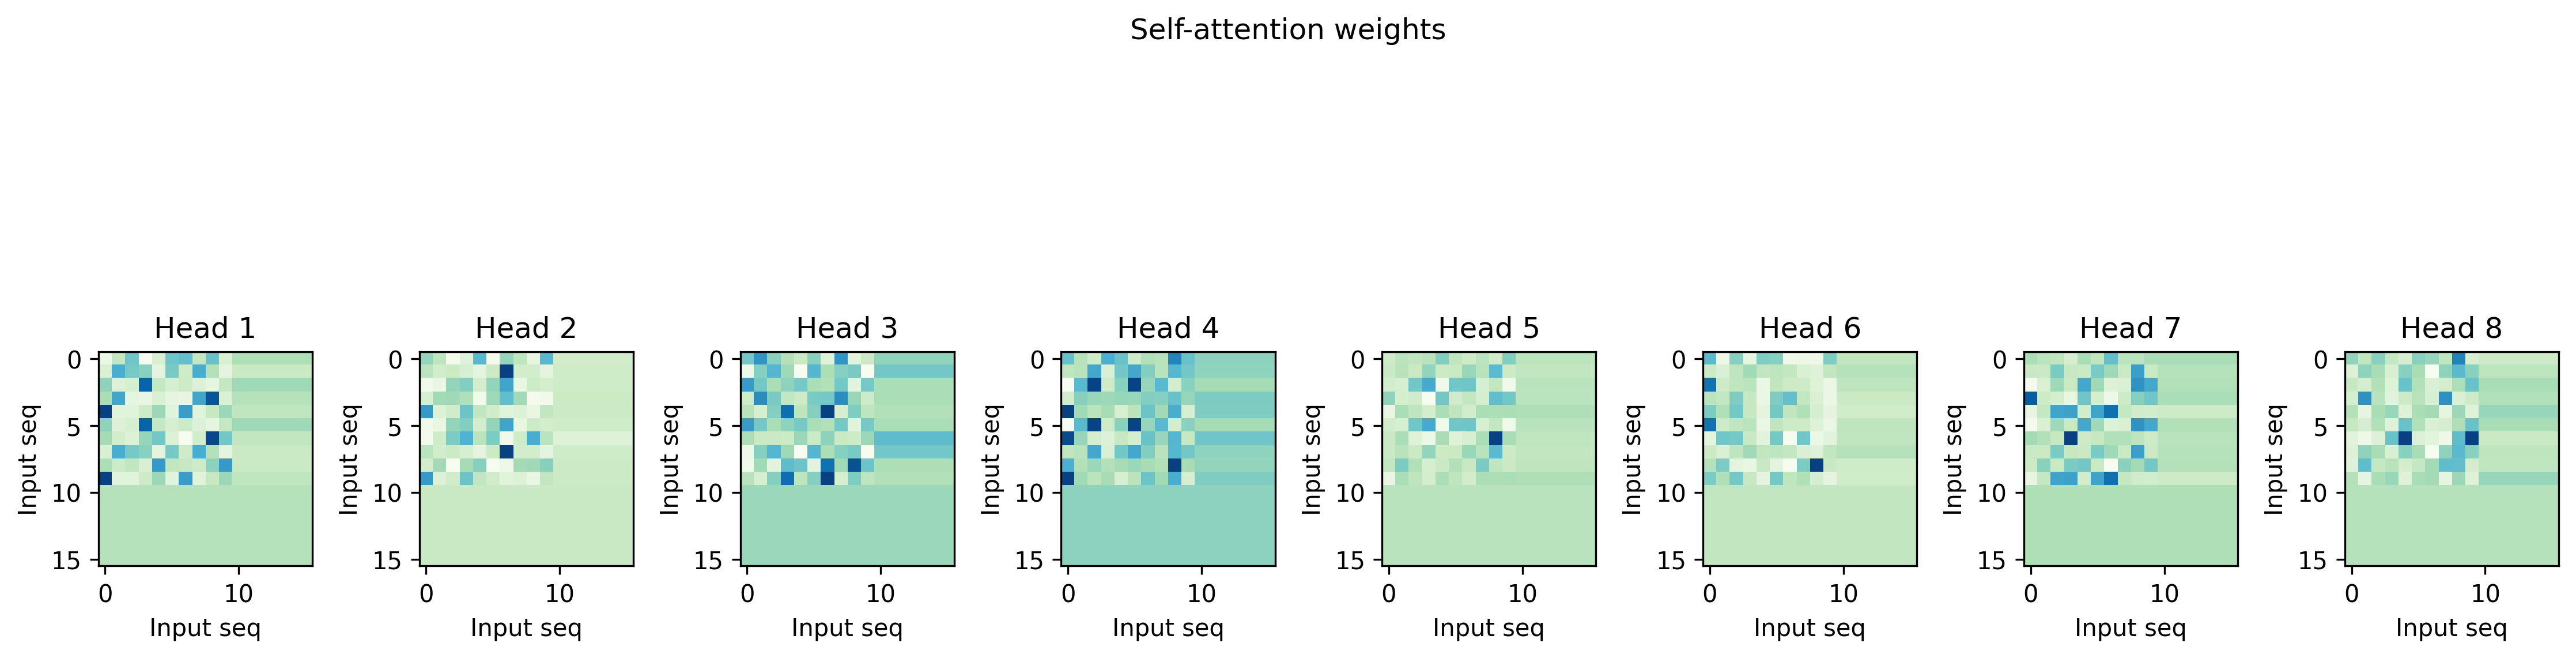

In [53]:
plot_attention(self_attn_w)

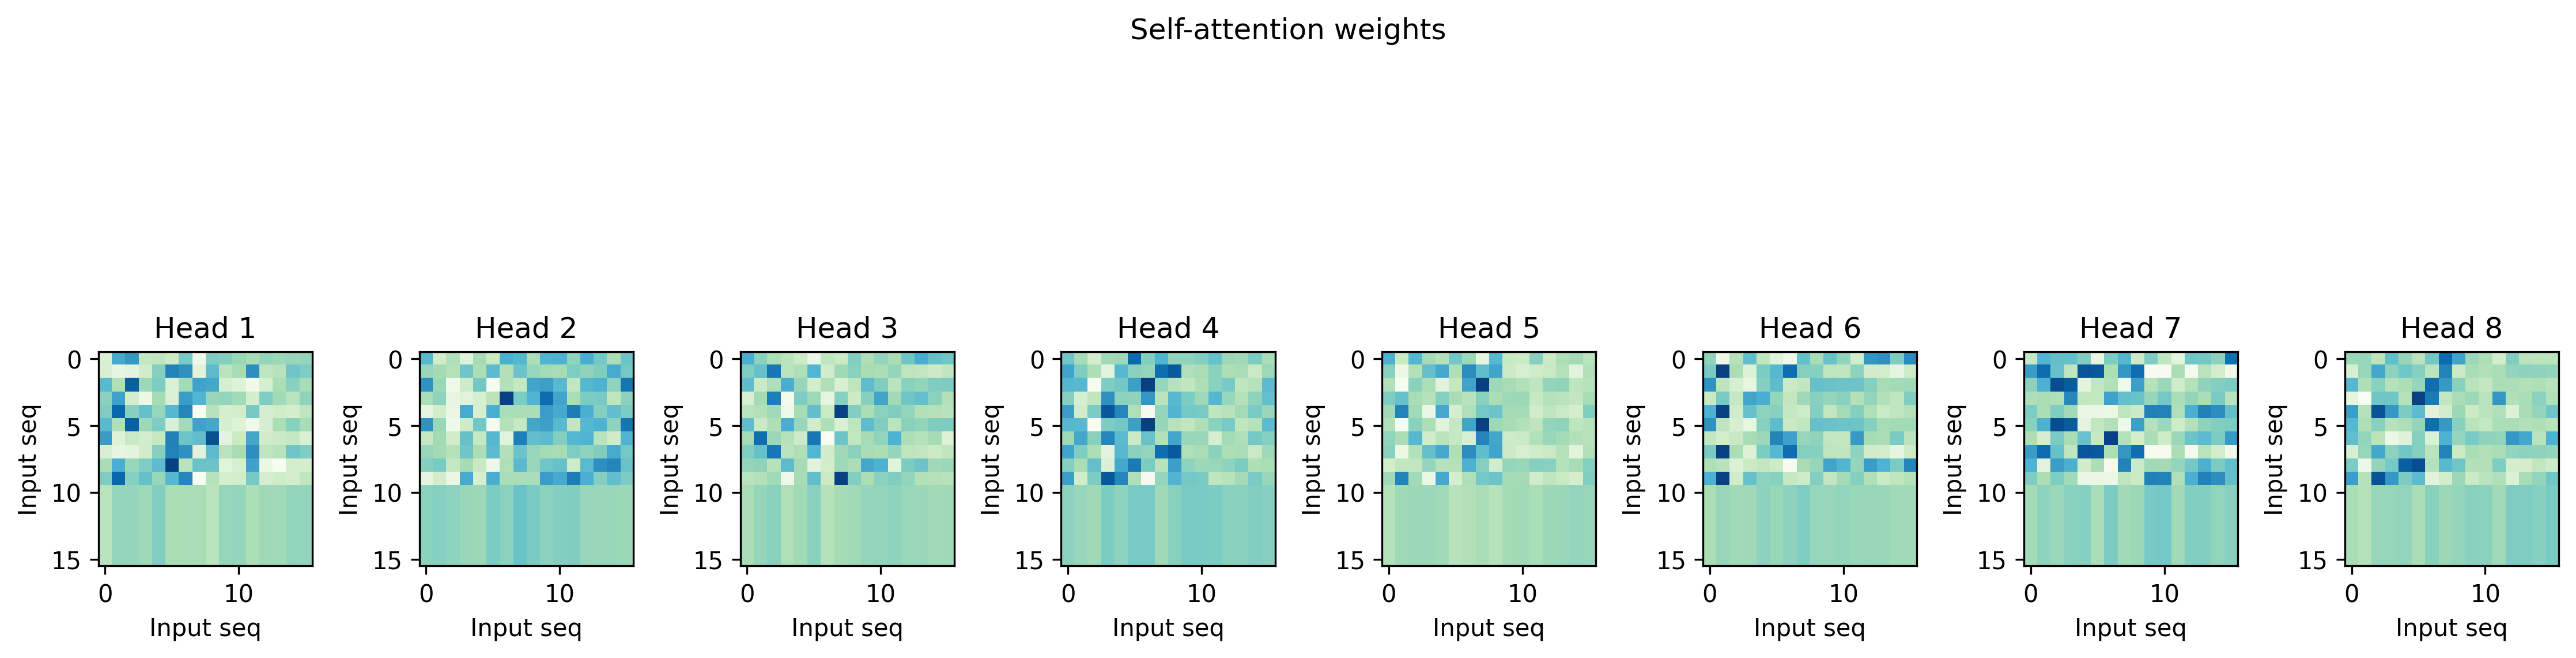

In [54]:
plot_attention(cross_attn_ws_seq)

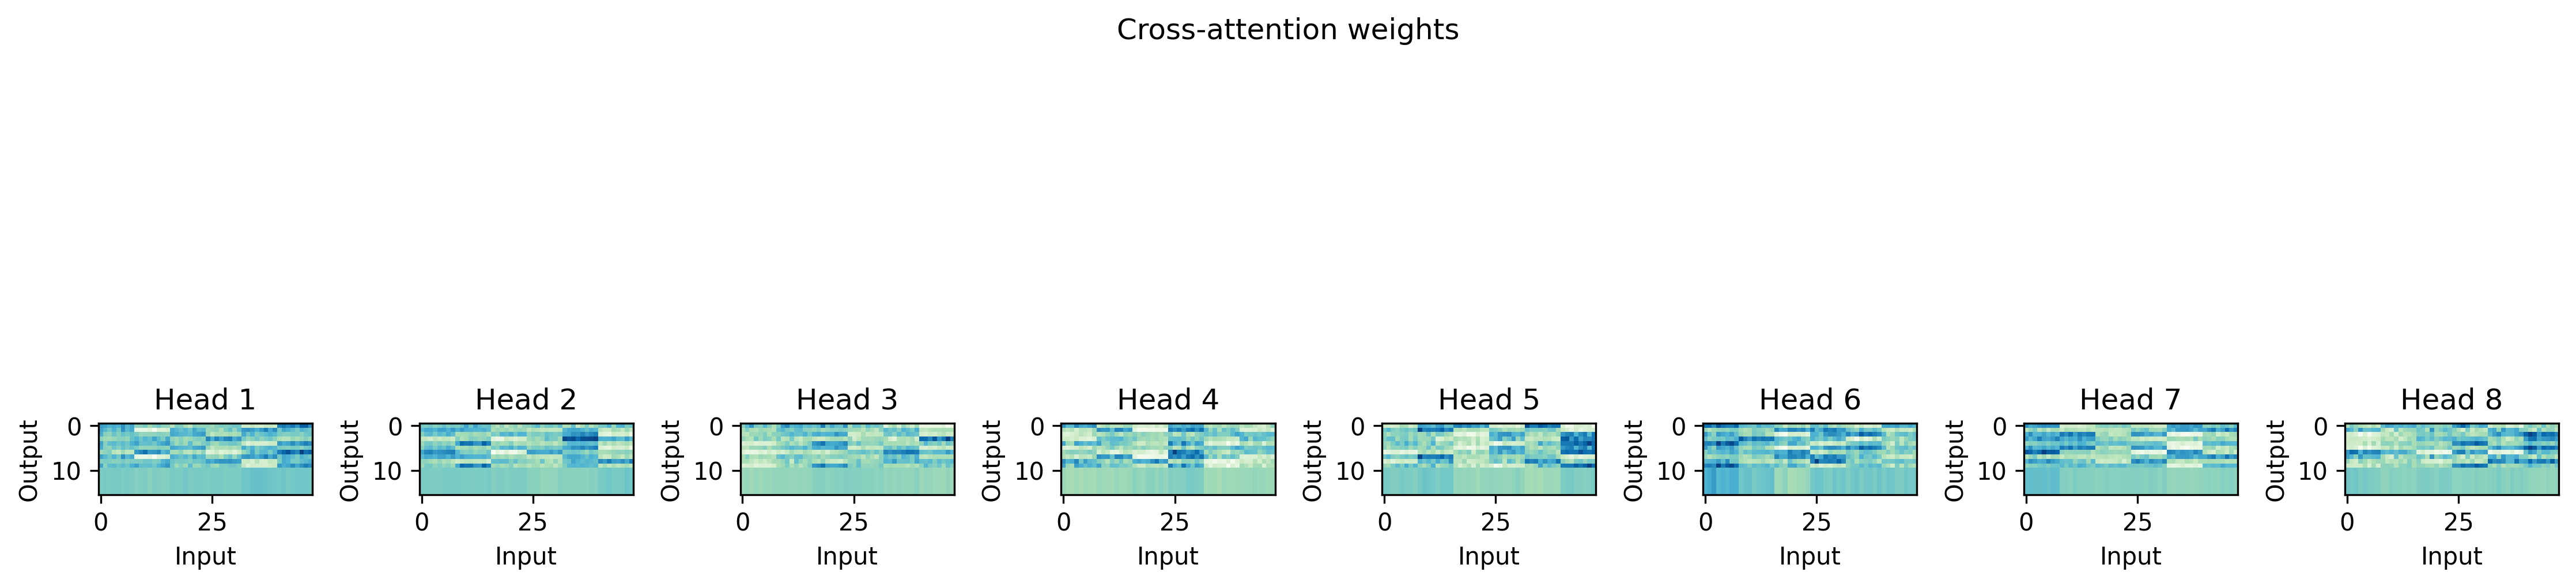

In [55]:
plot_attention(cross_attn_ws_tokens)

#### Test Transformer decoder

In [16]:
dec = TransformerDecoder(num_layers=1).cuda()
print(dec)
dec.eval()
summary(model=dec)

TransformerDecoder(
  (token_emb): Linear(in_features=512, out_features=512, bias=False)
  (position_emb): Linear(in_features=16, out_features=512, bias=False)
  (layers): ModuleList(
    (0): TransformerDecoderLayer(
      (self_attn): MultiHeadSelfAttention(
        (attention_heads): ModuleList(
          (0-7): 8 x SelfAttentionHead(
            (dropout): Dropout(p=0.2, inplace=False)
            (_softmax): Softmax(dim=-1)
            (w_q): Linear(in_features=512, out_features=512, bias=False)
            (w_k): Linear(in_features=512, out_features=512, bias=False)
            (w_v): Linear(in_features=512, out_features=512, bias=False)
          )
        )
        (output_layer): Sequential(
          (0): Linear(in_features=4096, out_features=512, bias=False)
          (1): Dropout(p=0.2, inplace=False)
        )
      )
      (cross_attn): MultiHeadSelfAttention(
        (attention_heads): ModuleList(
          (0-7): 8 x SelfAttentionHead(
            (dropout): Dropout(p=0

===========================================================================
Layer (type:depth-idx)                             Param #
===========================================================================
TransformerDecoder                                 --
├─Linear: 1-1                                      262,144
├─Linear: 1-2                                      8,192
├─ModuleList: 1-3                                  --
│    └─TransformerDecoderLayer: 2-1                --
│    │    └─MultiHeadSelfAttention: 3-1            8,388,608
│    │    └─MultiHeadSelfAttention: 3-2            8,388,608
│    │    └─LayerNormalization: 3-3                1,024
│    │    └─LayerNormalization: 3-4                1,024
│    │    └─Sequential: 3-5                        2,099,712
│    │    └─LayerNorm: 3-6                         1,024
│    │    └─Dropout: 3-7                           --
===========================================================================
Total params: 19,150,336
Trainable params: 19,150,336
Non-trainable params: 0
===========================================================================

#### With (Seq) positional encooding

In [46]:
# pos_embedding = PositionalEncoder(seq_len=config.MAX_LEN).cuda()

In [47]:
# outp_emb_ = pos_embedding(outp_emb)

In [48]:
# dec_out, self_attn_ws, cross_attn_ws = dec(
#     inp=outp_emb_, 
#     encoder_out=learned_tokens, 
#     src_mask=batch["source_mask"].cuda(), 
#     target_mask=batch["target_mask"].cuda(), 
#     debug=False
# )

# dec_out.shape, self_attn_ws.shape, cross_attn_ws.shape

(torch.Size([8, 16, 512]),
 torch.Size([8, 8, 16, 16]),
 torch.Size([8, 8, 16, 48]))

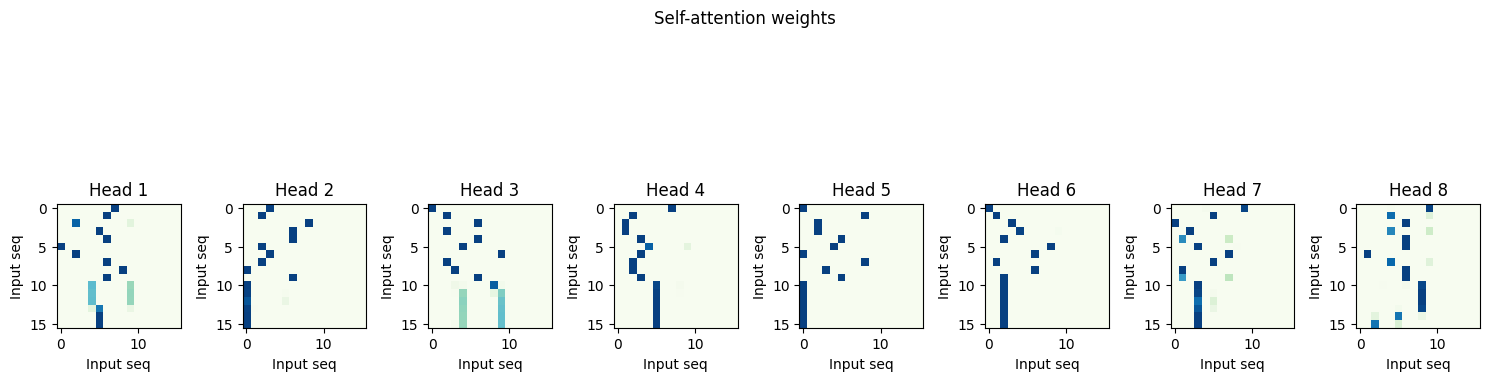

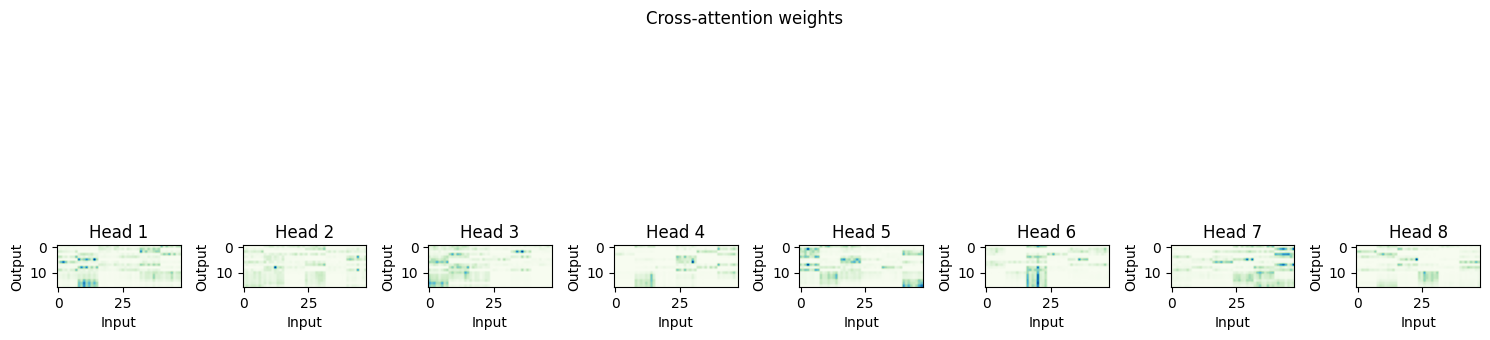

In [49]:
# plot_attention(self_attn_ws)
# plot_attention(cross_attn_ws)

#### With Linear positional encooding (similar to tf RT1)

In [24]:
outp_emb.shape

torch.Size([8, 16, 512])

In [26]:
dec_out, self_attn_ws, cross_attn_ws_seq, cross_attn_ws_tokens = dec(
    inp=outp_emb, 
    encoder_outs=(text_enc_h_state, learned_tokens), 
    src_mask=(batch["source_mask"].cuda(), batch["source_mask_tokens"].cuda()), 
    target_mask=batch["target_mask"].cuda(), 
    debug=False
)

dec_out.shape, self_attn_ws.shape, cross_attn_ws_seq.shape, cross_attn_ws_tokens.shape

(torch.Size([8, 16, 512]),
 torch.Size([8, 8, 16, 16]),
 torch.Size([8, 8, 16, 16]),
 torch.Size([8, 8, 16, 48]))

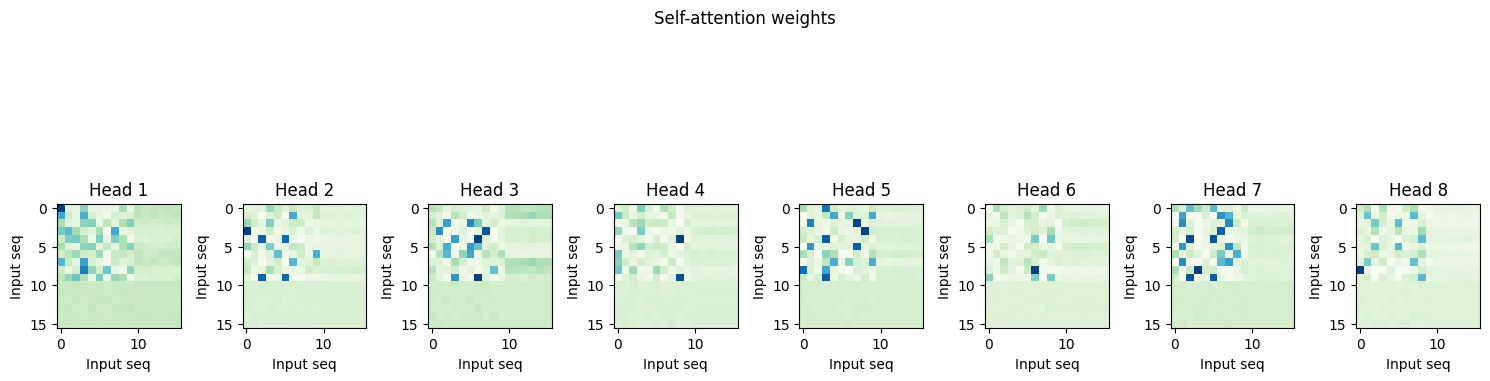

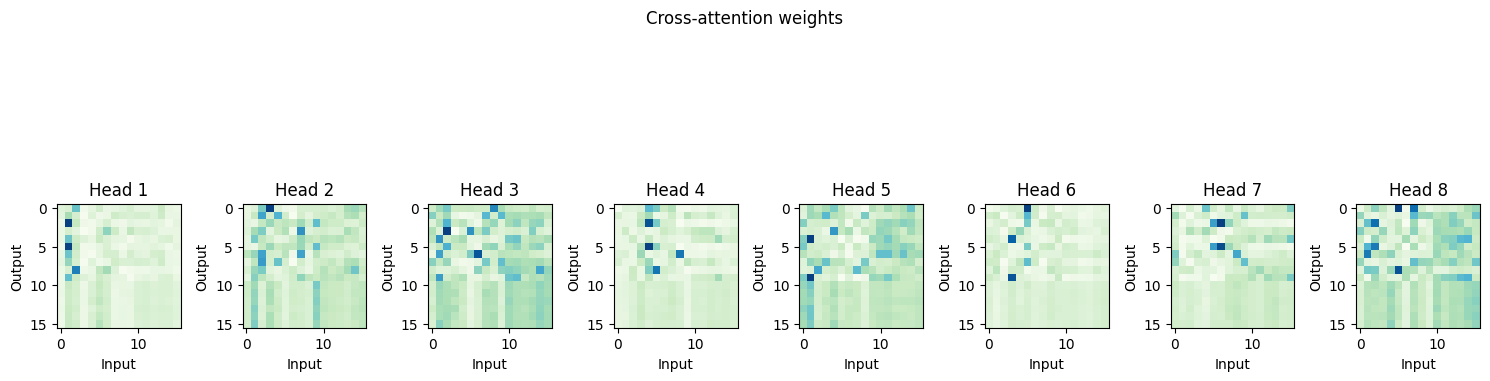

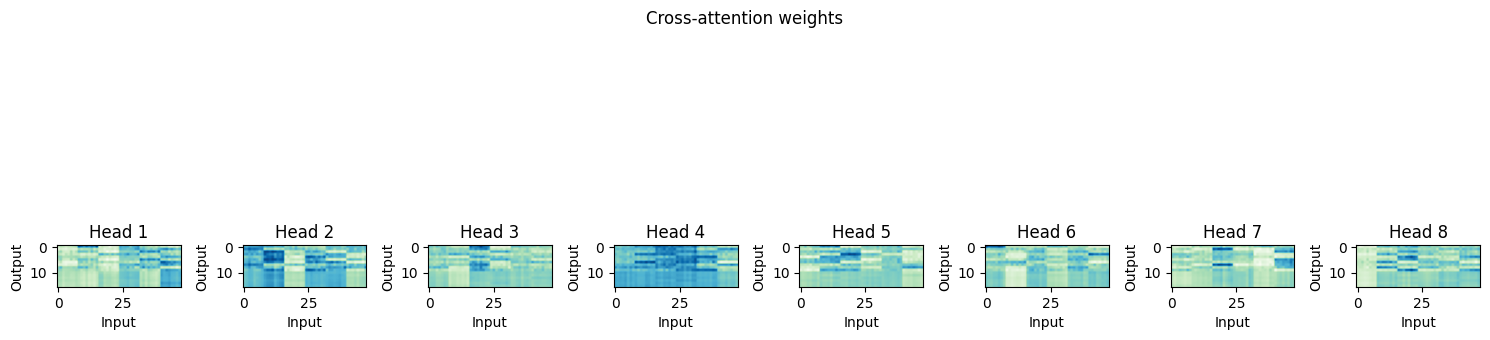

In [35]:
plot_attention(self_attn_ws)
plot_attention(cross_attn_ws_seq, kind="cross")
plot_attention(cross_attn_ws_tokens)

#### Action Generator

In [390]:
generator = ActionGenerator().cuda()
print(generator)
summary(generator)

ActionGenerator(
  (proj): Sequential(
    (0): Linear(in_features=512, out_features=52, bias=True)
    (1): Dropout(p=0.15, inplace=False)
  )
  (_softmax): LogSoftmax(dim=-1)
)


Layer (type:depth-idx)                   Param #
ActionGenerator                          --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       26,676
│    └─Dropout: 2-2                      --
├─LogSoftmax: 1-2                        --
Total params: 26,676
Trainable params: 26,676
Non-trainable params: 0

In [392]:
preds = generator(dec_out)
preds.shape

torch.Size([4, 16, 52])

In [393]:
predicted_next_tok = preds[:, -1, :].argmax(dim=-1)
predicted_next_tok.shape, predicted_next_tok

(torch.Size([4]), tensor([5, 5, 5, 5], device='cuda:0'))

### RT-1 Decoder

In [41]:
decoder = RT1Decoder(num_decoder_layers=1).cuda()
print(decoder)
decoder.eval()
summary(model=decoder)

RT1Decoder(
  (target_embedding): Embedding(52, 512, padding_idx=0)
  (transformer): TransformerDecoder(
    (token_emb): Linear(in_features=512, out_features=512, bias=False)
    (position_emb): Linear(in_features=16, out_features=512, bias=False)
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiHeadSelfAttention(
          (attention_heads): ModuleList(
            (0-7): 8 x SelfAttentionHead(
              (dropout): Dropout(p=0.2, inplace=False)
              (_softmax): Softmax(dim=-1)
              (w_q): Linear(in_features=512, out_features=512, bias=False)
              (w_k): Linear(in_features=512, out_features=512, bias=False)
              (w_v): Linear(in_features=512, out_features=512, bias=False)
            )
          )
          (output_layer): Sequential(
            (0): Linear(in_features=4096, out_features=512, bias=False)
            (1): Dropout(p=0.2, inplace=False)
          )
        )
        (cross_attn): MultiHeadSel

Layer (type:depth-idx)                                  Param #
RT1Decoder                                              --
├─Embedding: 1-1                                        26,624
├─TransformerDecoder: 1-2                               --
│    └─Linear: 2-1                                      262,144
│    └─Linear: 2-2                                      8,192
│    └─ModuleList: 2-3                                  --
│    │    └─TransformerDecoderLayer: 3-1                18,880,000
├─LayerNormalization: 1-3                               --
│    └─LayerNorm: 2-4                                   1,024
├─ActionGenerator: 1-4                                  --
│    └─Sequential: 2-5                                  --
│    │    └─Linear: 3-2                                 26,676
│    │    └─Dropout: 3-3                                --
│    └─LogSoftmax: 2-6                                  --
Total params: 19,204,660
Trainable params: 19,204,660
Non-trainable params: 0

In [43]:
%time

preds, self_attn_ws, cross_attn_ws_seq, cross_attn_ws_tokens = decoder(
    inp=batch["motor_cmd"]["decoder_inp_ids"].cuda(), 
    encoder_outs=(text_enc_h_state, learned_tokens), 
    src_mask=(batch["source_mask"].cuda(), batch["source_mask_tokens"].cuda()), 
    target_mask=batch["target_mask"].cuda(), 
    debug=False
)

preds.shape, self_attn_ws.shape, cross_attn_ws_seq.shape, cross_attn_ws_tokens.shape

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


(torch.Size([8, 16, 52]),
 torch.Size([8, 8, 16, 16]),
 torch.Size([8, 8, 16, 16]),
 torch.Size([8, 8, 16, 48]))

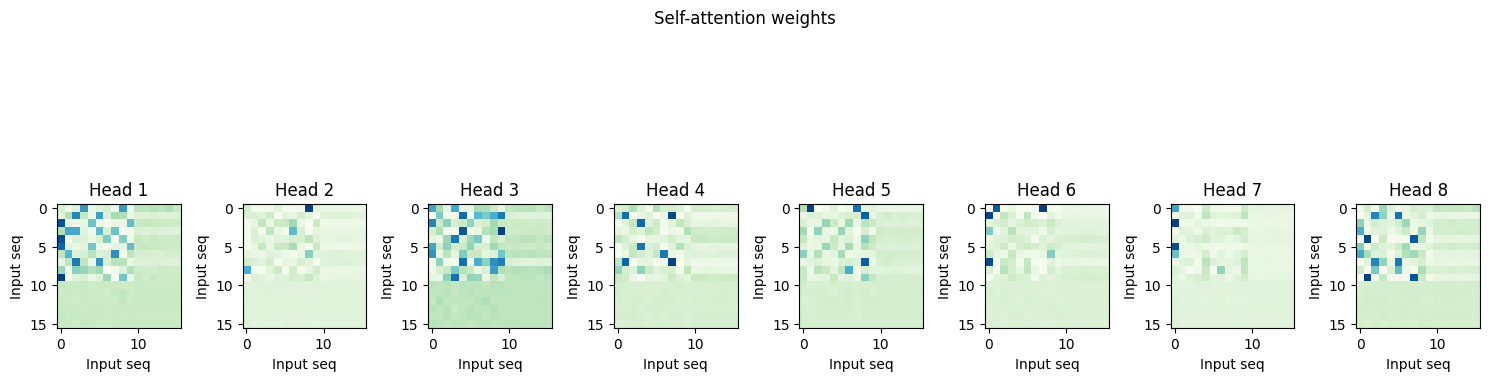

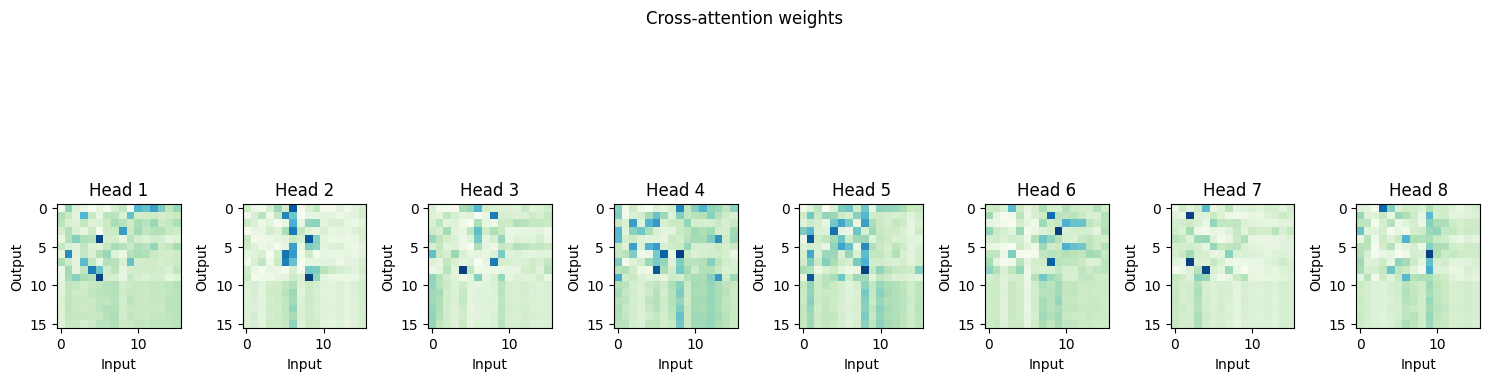

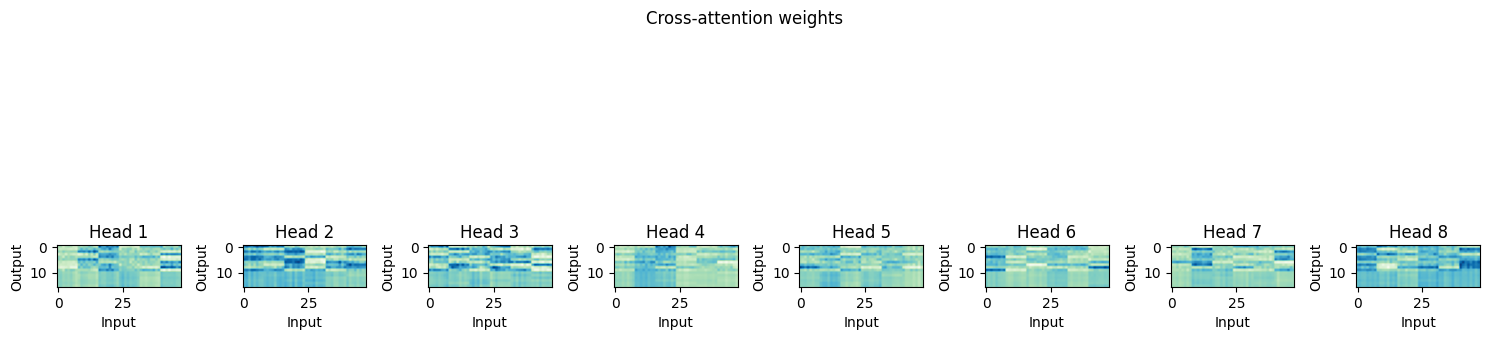

In [44]:
plot_attention(self_attn_ws)
plot_attention(cross_attn_ws_seq, kind="cross")
plot_attention(cross_attn_ws_tokens)

## RT1-CRAM

In [12]:
# pretty progress bar
%load_ext rich

In [15]:
rt1 = RT1CRAM(
    cnn_bacnbone=config.SELECTED_CNN_BACKBONE, 
    num_res_blocks=config.NUM_RES_BLOCKS,
    freeze_cnn_backbone=config.PRETRAINED_CNN
)#.cuda()
# print(rt1)

summary(model=rt1)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b3.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnet_b3.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


==========================================================================================
Layer (type:depth-idx)                                            Param #
==========================================================================================
RT1CRAM                                                           --
├─RT1Encoder: 1-1                                                 --
│    └─TextEncoder: 2-1                                           --
│    │    └─BertModel: 3-1                                        (28,763,648)
│    │    └─Dropout: 3-2                                          --
│    └─FiLMEncoder: 2-2                                           --
│    │    └─ImageFeatureExtractor: 3-3                            10,300,456
│    │    └─ModuleList: 3-4                                       3,170,304
│    └─TokenLearnerV11: 2-3                                       --
│    │    └─Sequential: 3-5                                       34,376
├─RT1Decoder: 1-2                                                 --
│    └─Embedding: 2-4                                             26,624
│    └─TransformerDecoder: 2-5                                    --
│    │    └─Linear: 3-6                                           262,144
│    │    └─Linear: 3-7                                           8,192
│    │    └─ModuleList: 3-8                                       20,982,784
│    └─LayerNormalization: 2-6                                    --
│    │    └─LayerNorm: 3-9                                        1,024
│    └─ActionGenerator: 2-7                                       --
│    │    └─Sequential: 3-10                                      26,676
├─CrossEntropyLoss: 1-3                                           --
├─CharErrorRate: 1-4                                              --
├─WordErrorRate: 1-5                                              --
==========================================================================================
Total params: 63,576,228
Trainable params: 34,812,580
Non-trainable params: 28,763,648
==========================================================================================

### Training

In [16]:
_ = seed_everything(config.SEED)

[rank: 0] Seed set to 1234


#### RT-1 Forward pass

In [15]:
input_ids.shape, attn_mask.shape, imgs.shape

(torch.Size([16, 16]), torch.Size([16, 16]), torch.Size([16, 3, 288, 288]))

In [40]:
 preds, self_attn_ws, cross_attn_ws_seq, cross_attn_ws_tokens = rt1(
    input_ids=input_ids, 
    attn_mask=attn_mask, 
    token_type_ids=token_type_ids, 
    imgs=imgs,
    decoder_inp=decoder_inp, 
    src_mask=src_mask, 
    target_mask=target_mask 
)
    
preds.shape, self_attn_ws.shape, cross_attn_ws_seq.shape, cross_attn_ws_tokens.shape

(
    torch.Size([4, 16, 52]),
    torch.Size([4, 2, 4, 16, 16]),
    torch.Size([4, 2, 4, 16, 16]),
    torch.Size([4, 4, 16, 48])
)

#### Progress bar workaround
> from: https://github.com/Lightning-AI/lightning/issues/15283

In [41]:
class MyProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        if not sys.stdout.isatty():
            bar.disable = True
        return bar

    def init_predict_tqdm(self):
        bar = super().init_predict_tqdm()
        if not sys.stdout.isatty():
            bar.disable = True
        return bar

    def init_test_tqdm(self):
        bar = super().init_test_tqdm()
        if not sys.stdout.isatty():
            bar.disable = True
        return bar

#### Loggers & Callbacks

In [17]:
wandb_logger = WandbLogger(
    name="be_model",
    project='SMF-Be', 
    log_model=True, 
    save_dir=config.LOGS_PATH,
    checkpoint_name="be_model"
)

# callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    mode="min",
    dirpath=config.MODEL_PATH,
    filename='be_model',
    auto_insert_metric_name=False,
    save_on_train_epoch_end=False,
    every_n_epochs=1
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')

#### Experiment

In [18]:

# create your own theme!
progress_bar = RichProgressBar(
    theme=RichProgressBarTheme(
        description="#1A1717",
        # progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="#1A1717",
        time="#1A1717",
        processing_speed="#1A1717",
        metrics="#1A1717",
        metrics_text_delimiter="\n",
        metrics_format=".3f",
    ),
    leave=True
)

trainer = Trainer(
    enable_progress_bar=True,
    # deterministic=True, 
    min_epochs=2, 
    max_epochs=config.EPOCHS, 
    gradient_clip_val=config.GRAD_CLIP_VAL, 
    # fast_dev_run=True,
    callbacks=[
        progress_bar,
        lr_monitor,
        # MyProgressBar()
    ],
    logger=wandb_logger
)

dm = BEDataModule()
trainer.fit(model=rt1, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dric225 (jepsam-s23). Use `wandb login --relogin` to force relogin


wandb version 0.16.0 is available! To upgrade, please run:
 $ pip install wandb --upgrade

Tracking run with wandb version 0.15.12

Run data is saved locally in ../logs/wandb/run-20231108_045259-vljqflfy

Syncing run be_model to Weights & Biases ( docs )

View project at https://wandb.ai/jepsam-s23/SMF-Be

View run at https://wandb.ai/jepsam-s23/SMF-Be/runs/vljqflfy

INFO:root:Training on 3853 samples.
INFO:root:Validating on 655 samples.
INFO:root:Testing on 250 samples.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Total # examples: 4758


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ encoder │ RT1Encoder       │ 42.3 M │
│ 1 │ decoder │ RT1Decoder       │ 21.3 M │
│ 2 │ loss_fn │ CrossEntropyLoss │      0 │
│ 3 │ cer_fn  │ CharErrorRate    │      0 │
│ 4 │ wer_fn  │ WordErrorRate    │      0 │
└───┴─────────┴──────────────────┴────────┘

Trainable params: 34.8 M                                                                                           
Non-trainable params: 28.8 M                                                                                       
Total params: 63.5 M                                                                                               
Total estimated model params size (MB): 254

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

ERROR:root:Training was manually stopped because attention NaNs encountered in cross-attention weights.


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


## Tests

#### Forward

##### Load model from ckpt

In [20]:
os.listdir(os.path.join(config.LOGS_PATH, "SMF-Be/vljqflfy/checkpoints"))

['epoch=19-step=4820.ckpt']

In [22]:
PATH = os.path.join(
    config.LOGS_PATH, 
    "SMF-Be/vljqflfy/checkpoints/epoch=19-step=4820.ckpt"
)
rt1 = RT1CRAM.load_from_checkpoint(PATH)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b3.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnet_b3.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_55279/3147391277.py:5 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_55279/3147391277.py'                        │
│                                                                                                  │
│ /ocean/projects/cis230036p/cmanouan/miniconda3/envs/smf_be/lib/python3.10/site-packages/lightnin │
│ g/pytorch/core/module.py:1552 in load_from_checkpoint                                            │
│                                                                                                  │
│   1549 │   │   │   y_hat = pretrained_model(x)                                                   │
│   1550 │   │                                                                                     │
│   1551 │   │   """                                                                               │
│ ❱ 1552 │   │   loaded = _load_from_checkpoint(                                                   │
│   1553 │   │   │   cls,  # type: ignore[arg-type]                                                │
│   1554 │   │   │   checkpoint_path,                                                              │
│   1555 │   │   │   map_location,                                                                 │
│                                                                                                  │
│ /ocean/projects/cis230036p/cmanouan/miniconda3/envs/smf_be/lib/python3.10/site-packages/lightnin │
│ g/pytorch/core/saving.py:89 in _load_from_checkpoint                                             │
│                                                                                                  │
│    86 │   if issubclass(cls, pl.LightningDataModule):                                            │
│    87 │   │   return _load_state(cls, checkpoint, **kwargs)                                      │
│    88 │   if issubclass(cls, pl.LightningModule):                                                │
│ ❱  89 │   │   model = _load_state(cls, checkpoint, strict=strict, **kwargs)                      │
│    90 │   │   state_dict = checkpoint["state_dict"]                                              │
│    91 │   │   if not state_dict:                                                                 │
│    92 │   │   │   rank_zero_warn(f"The state dict in {checkpoint_path!r} contains no parameter   │
│                                                                                                  │
│ /ocean/projects/cis230036p/cmanouan/miniconda3/envs/smf_be/lib/python3.10/site-packages/lightnin │
│ g/pytorch/core/saving.py:169 in _load_state                                                      │
│                                                                                                  │
│   166 │                                                                                          │
│   167 │   # load the state_dict on the model automatically                                       │
│   168 │   assert strict is not None                                                              │
│ ❱ 169 │   keys = obj.load_state_dict(checkpoint["state_dict"], strict=strict)                    │
│   170 │                                                                                          │
│   171 │   if not strict:                                                                         │
│   172 │   │   if keys.missing_keys:                                                              │
│                                                                                                  │
│ /ocean/projects/cis230036p/cmanouan/miniconda3/envs/smf_be/lib/python3.10/site-packages/torch/nn │
│ /modules/module.py:2041 in load_state_dict                 

##### Run forward pass

In [19]:
rt1.cuda()
rt1.eval()
logits, self_attn_ws, cross_attn_ws_seq, cross_attn_ws_tokens  = rt1(
    input_ids=input_ids, 
    attn_mask=attn_mask, 
    token_type_ids=token_type_ids, 
    imgs=imgs,
    decoder_inp=decoder_inp, 
    src_mask=src_mask, 
    target_mask=target_mask 
)

preds = logits.softmax(dim=-1).argmax(dim=-1)


In [21]:
model_utils.has_nan(cross_attn_ws_tokens)

True

In [23]:
preds[0]

tensor([21, 41, 28,  8, 46, 36, 21, 44,  8,  2, 21, 21, 21, 21, 21, 21],
       device='cuda:0')

In [25]:
rt1.decode_predictions(predicted_ids=preds[0].unsqueeze(0))

[
    ":BOWL GREEN POSE-8 :BOTTLE BLUE POSE-3 :BOWL #'*forward-transformation* :BOTTLE [EOS] :BOWL :BOWL :BOWL :BOWL :BOWL :BOWL"
]

In [26]:
rt1.decode_predictions(
    predicted_ids=batch["motor_cmd"]["labels"][0].unsqueeze(0)
)

[
    ":BOWL GREEN POSE-8 :BOTTLE BLUE POSE-3 :BOWL #'*forward-transformation* :BOTTLE [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"
]

#### Visualize learned attention weights

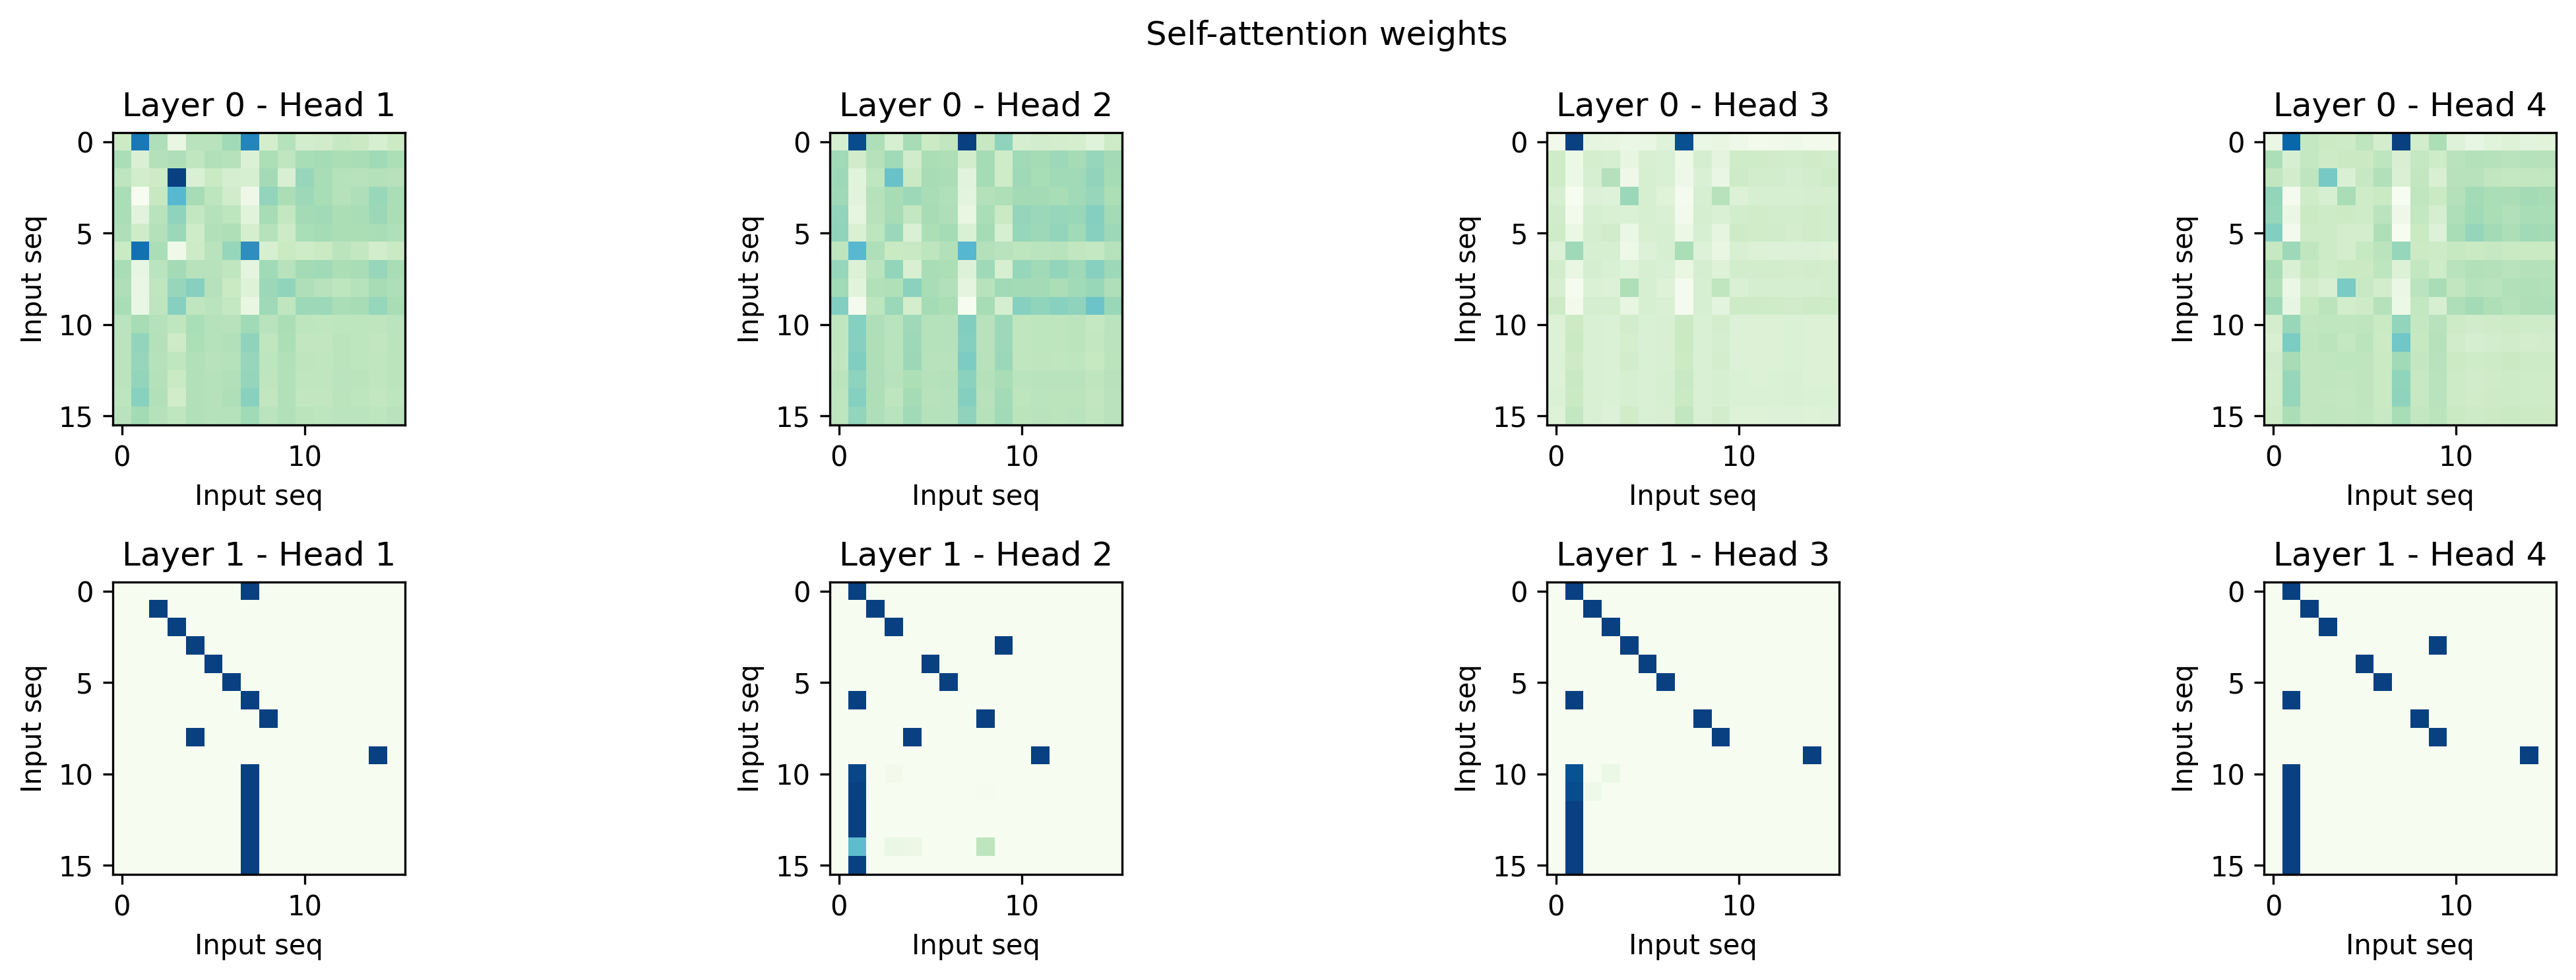

In [27]:
plot_attention(self_attn_ws, show=True, pre_fix="train_selfattn")

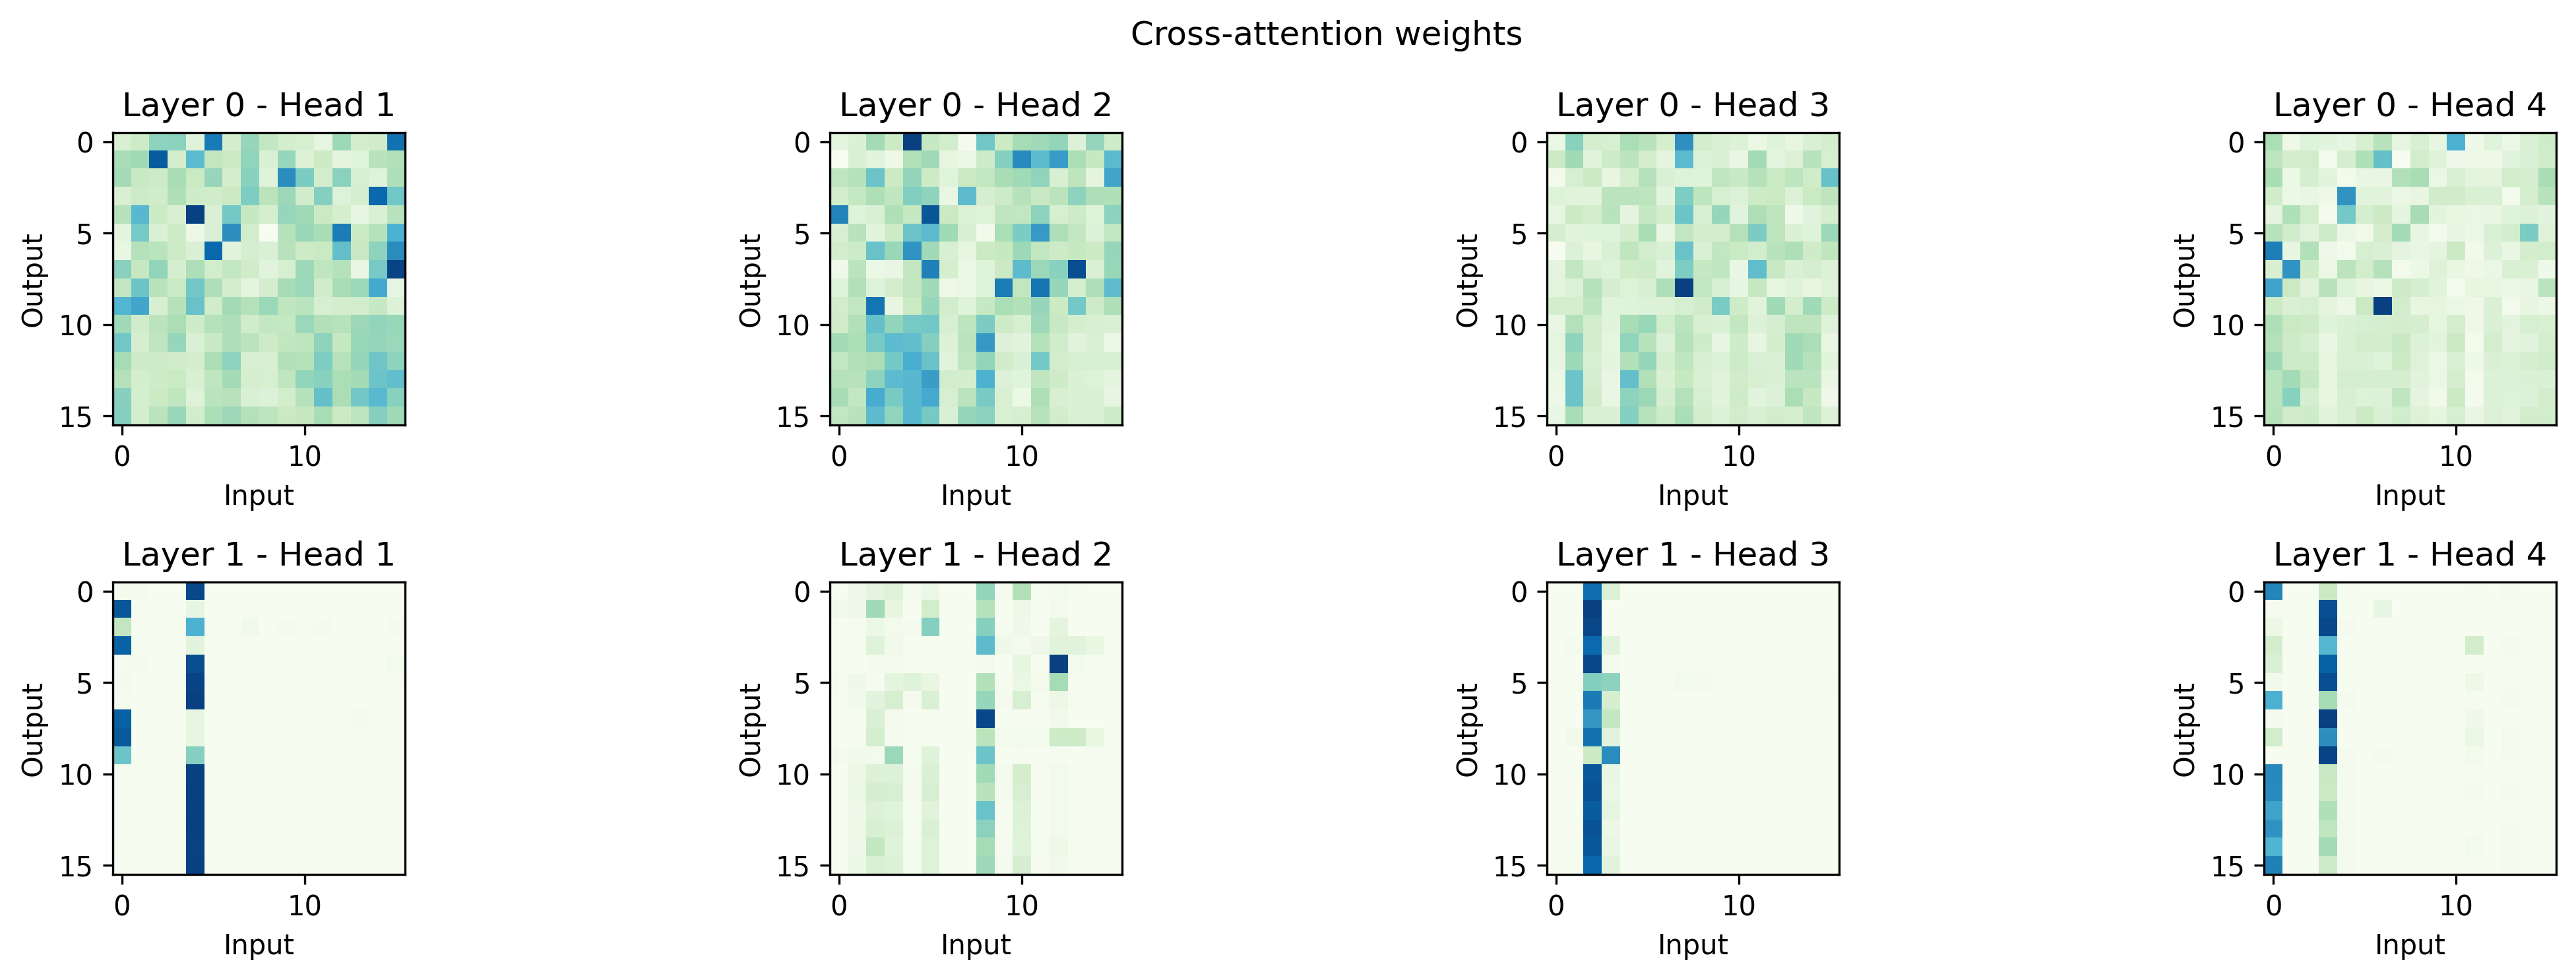

In [28]:
plot_attention(cross_attn_ws_seq, kind="cross", pre_fix="train_crossattn", show=True)

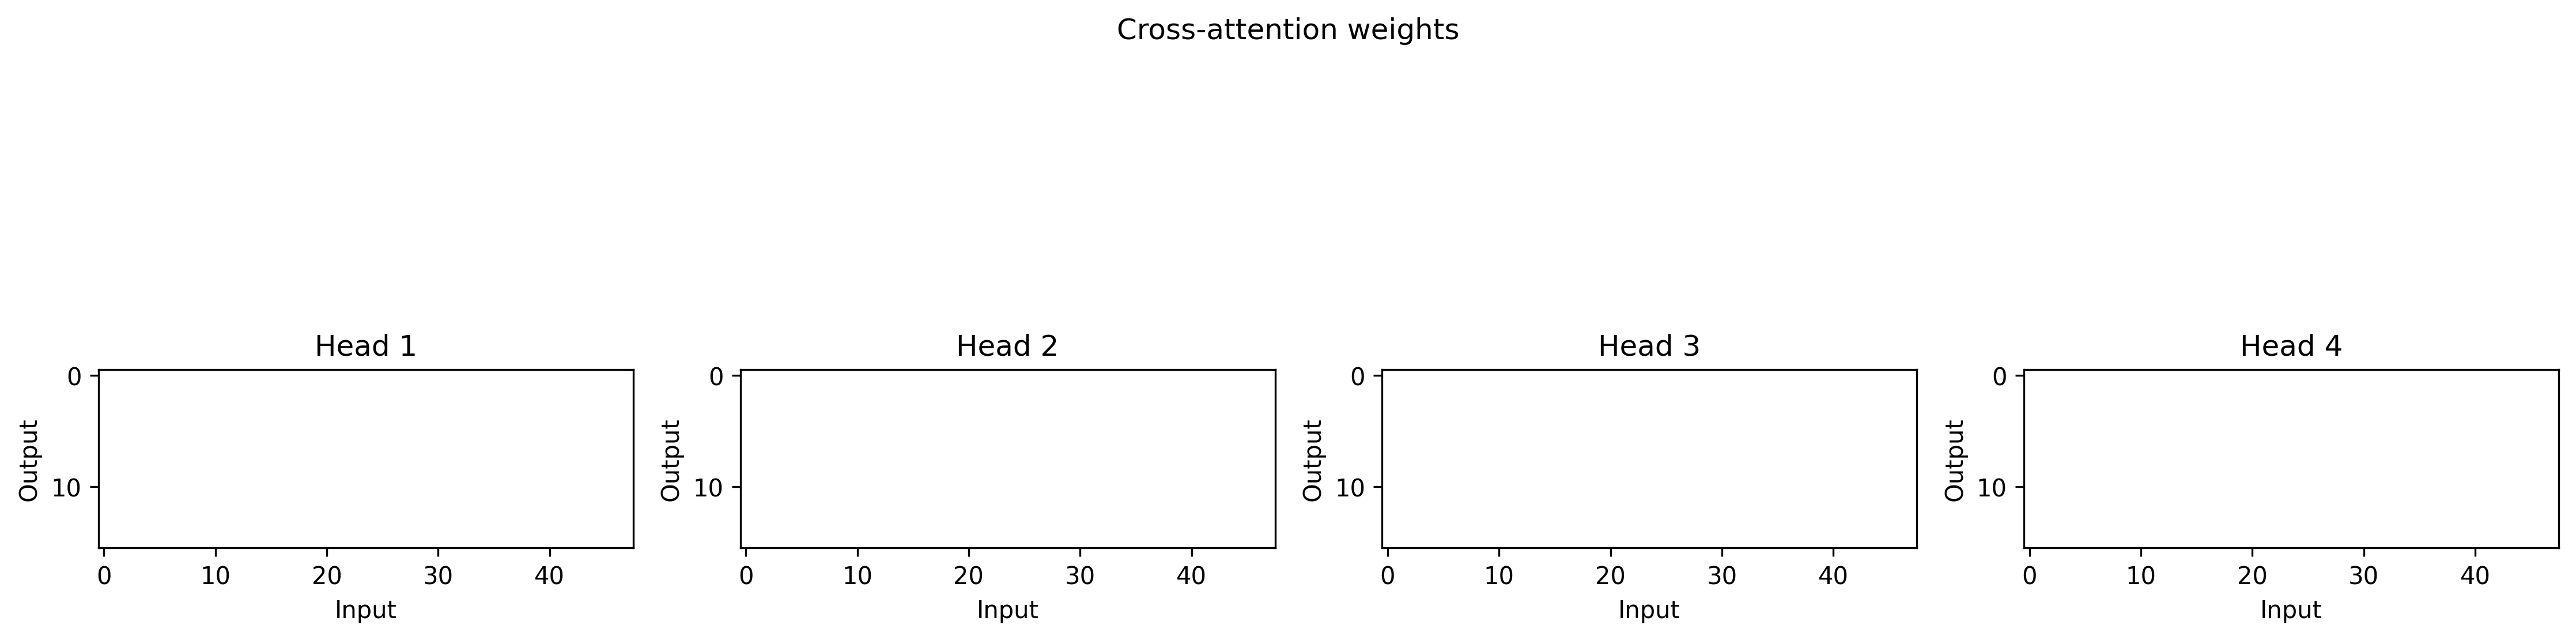

In [29]:
plot_attention(cross_attn_ws_tokens, pre_fix="train_crossattn_tokens", show=True)

In [30]:
cross_attn_ws_tokens

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        ...,


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan

In [21]:
bt = fetch_random_sample_from_batch(batch, batch_size=config.BATCH_SIZE)

In [22]:
oo = rt1.greedy_decoding(batch=bt)

In [23]:
rt1.decode_predictions(predicted_ids=oo.unsqueeze(0))

["[SOS] :GLASSES POSE-5 POSE-15 POSE-14 POSE-9 #'*rightward-transformation* :KNIFE POSE-11 POSE-11 :SHOE :KNIFE POSE-7 :KNIFE POSE-11 :BREAKFAST-CEREAL"]

In [24]:
rt1.decode_predictions(predicted_ids=bt["labels"])

[":CUP BLUE POSE-2 :CUP #'*forward-transformation* :CUP [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"]

### Garbage collector

In [22]:
mask = generate_causal_attention_mask(
            dim=decoder_inp.shape[1]
        ).type_as(attn_mask)

In [29]:
for t in range(1, mask.shape[1]):
    print(f"t={t} ", mask[:, t].cpu().detach().numpy().tolist())

t=1  [[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
t=2  [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
t=3  [[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
t=4  [[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
t=5  [[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
t=6  [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
t=7  [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]
t=8  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]]
t=9  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]
t=10  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]
t=11  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]]
t=12  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]]
t=13  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]
t=14  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]
t=15  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
